# Data Preparation
<hr>
This notebook is used to ingest and prepare data for various modules.
<hr>


## Set Up
Create the arrays based on Qilian mask. Have to run before all data ingestion.

In [2]:
import numpy as np
import pandas as pd

# Get coordinates for data
points_file = "input/qilian.txt"
pts = pd.read_csv(points_file)

# Get unique lat/lon for row/col mapping
lats = np.sort(pts["Latitude"].unique())[::-1]
lons = np.sort(pts["Longitude"].unique())

# Print minimum and maximum lat/lon to verify
print(lats[0])
print(lats[-1])
print(lons[0])
print(lons[-1])

# Map lat/lon to row/col
lat_to_row = {lat: i for i, lat in enumerate(lats)}
lon_to_col = {lon: j for j, lon in enumerate(lons)}

pts["row"] = pts["Latitude"].map(lat_to_row).astype(int)
pts["col"] = pts["Longitude"].map(lon_to_col).astype(int)

nrow, ncol = len(lats), len(lons)
ntime = 365  # for 1979

print(f"Grid size: {nrow} rows x {ncol} cols")

39.721391739
35.921391739
93.663346096
102.863346096
Grid size: 39 rows x 93 cols


## Climate Data

In [ ]:
import os

# Change data root depending on the location of the data
data_root = '/Volumes/thesisDrive/Climate data/Daily'
#data_root = '/Volumes/thesisDrive/Permafrost Data TP/daily/Climate data/daily'

# === Config ===
variables = ["TempMean"]
years = range(1980, 2019)  # 1979-2018

# === Output folder for .npy files ===
output_folder = "../data_input/climate_yearly"
os.makedirs(output_folder, exist_ok=True)

# === Loop through each year ===
for year in years:
    print(f"Processing year {year}...")

    # Create a folder for this year
    year_folder = os.path.join(output_folder, str(year))
    os.makedirs(year_folder, exist_ok=True)
    
    # Initialize arrays for this year
    ntime = 366 if pd.Timestamp(year=year, month=12, day=31).is_leap_year else 365
    arrays = {var: np.zeros((nrow, ncol, ntime), dtype=np.float32) for var in variables}
    
    # Loop over each point/folder
    for idx, row in pts.iterrows():
        lat, lon = row["Latitude"], row["Longitude"]
        r, c = row["row"], row["col"]
        folder_name = f"{lon}_{lat}"
        file_path = os.path.join(data_root, folder_name, "Climate_data.txt")
        if not os.path.exists(file_path):
            folder_name = f" {lon}_{lat}"
            file_path = os.path.join(data_root, folder_name, "Climate_data.txt")
        if os.path.exists(file_path):
            df = pd.read_csv(file_path, sep="\t", parse_dates=["Date"])
            df_year = df[df["Date"].dt.year == year].reset_index(drop=True)
            
            # Fill arrays
            for var in variables:
                col_name = var
                r = int(r)
                c = int(c)  
                # Only fill up to the available number of days (in case leap year differences)
                arrays[var][r, c, :len(df_year)] = df_year[col_name].values

                values = df_year[col_name].values
            # Print the first 5 values if needed
            # print(
            #     f"{var} @ (r={r}, c={c}), "
            #     f"lat={lat}, lon={lon}, "
            #     f"first 5 days: {values[:5]}"
            # )

        else:
            print(f"Missing file: {file_path}")
    
    # Save arrays for this year in the year's folder
    for var, arr in arrays.items():
        npy_path = os.path.join(year_folder, f"{var}.npy")
        np.save(npy_path, arr)
        print(f"Saved {npy_path}")

print("All years processed!")


Processing year 1980...
Missing file: /Volumes/thesisDrive/Climate data/Daily/ 100.063346096_36.421391739/Climate_data.txt
Missing file: /Volumes/thesisDrive/Climate data/Daily/ 100.063346096_36.521391739/Climate_data.txt
Missing file: /Volumes/thesisDrive/Climate data/Daily/ 100.063346096_36.621391739/Climate_data.txt
Missing file: /Volumes/thesisDrive/Climate data/Daily/ 100.063346096_36.721391739/Climate_data.txt
Missing file: /Volumes/thesisDrive/Climate data/Daily/ 100.063346096_36.821391739/Climate_data.txt
Missing file: /Volumes/thesisDrive/Climate data/Daily/ 100.063346096_36.921391739/Climate_data.txt
Missing file: /Volumes/thesisDrive/Climate data/Daily/ 100.063346096_37.021391739/Climate_data.txt
Missing file: /Volumes/thesisDrive/Climate data/Daily/ 100.063346096_37.121391739/Climate_data.txt
Missing file: /Volumes/thesisDrive/Climate data/Daily/ 100.063346096_37.221391739/Climate_data.txt
Missing file: /Volumes/thesisDrive/Climate data/Daily/ 100.063346096_37.321391739/Cli

(39, 93, 365)


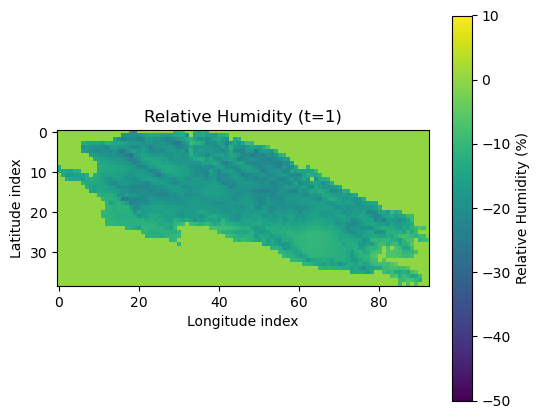

In [10]:
import matplotlib.pyplot as plt

t = 1 # time index

RH = np.load("../data_input/climate_yearly/1979/TempMean.npy")
print(RH.shape)

plt.figure(figsize=(6, 5))
plt.imshow(
    RH[:, :, t],
    cmap="viridis",
    vmin=-50,
    vmax=10,
)
plt.colorbar(label="Relative Humidity (%)")
plt.title(f"Relative Humidity (t={t})")
plt.xlabel("Longitude index")
plt.ylabel("Latitude index")
plt.show()

### 20-year Averages

In [ ]:
import numpy as np
import os

base_dir = "../data_input/climate_yearly"
variables = ["TempMean"]
periods = {
    "1979-1998": range(1979, 1999),
    "1999-2018": range(1999, 2019),
}

max_days = 365  # Set to 365 because of how the module processes data 

out_dir = "../data_input/climate_20yr_averages"
os.makedirs(out_dir, exist_ok=True)

period_daily_means = {}

for period_name, years in periods.items():
    print(f"Processing {period_name}...")
    period_daily_means[period_name] = {}

    for var in variables:
        daily_stack = []

        for year in years:
            path = os.path.join(base_dir, str(year), f"{var}.npy")
            arr = np.load(path)  # shape (nrow, ncol, ntime)
            nrow, ncol, ntime = arr.shape

            # Remove February 29 if it exists to ensure consistent shape across years
            if ntime > max_days:
                idx_feb29 = 59
                arr = np.delete(arr, idx_feb29, axis=-1)

            daily_stack.append(arr)

        # Stack: (nyears, nrow, ncol, max_days)
        stacked = np.stack(daily_stack, axis=0)
        mean_daily = stacked.mean(axis=0)  # mean over years → (nrow, ncol, max_days)

        period_daily_means[period_name][var] = mean_daily

        # Save each variable
        out_path = os.path.join(out_dir, period_name, f"{var}.npy")
        os.makedirs(os.path.dirname(out_path), exist_ok=True)
        np.save(out_path, mean_daily)
        print(f"Saved {out_path} | shape: {mean_daily.shape}")

Processing 1979-1998...
Saved ../data_input/climate_20yr_averages/1979-1998/TempMean.npy | shape: (39, 93, 365)
Processing 1999-2018...
Saved ../data_input/climate_20yr_averages/1999-2018/TempMean.npy | shape: (39, 93, 365)


### Save climate data as .tif for mapping purposes

In [6]:
import numpy as np
import rasterio
from rasterio.transform import from_origin

# Replace with your actual file path
arr = np.load("../data_input/climate_yearly/1979/RH.npy")  # shape: (rows, cols, time)

# --- Select the day you want ---
day_index = 0  # 0 = first day, 1 = second day, etc.
arr_day = arr[:, :, day_index]

# Grid georeferencing (upper-left corner of your grid)
x_min = 93.663346096
y_max = 39.721391739  # adjust to your actual coordinates
pixel_size = 0.1            # 0.1 degree


'''
39.721391739
35.921391739
93.663346096
102.863346096
'''

transform = from_origin(x_min, y_max, pixel_size, pixel_size)

# Output path
out_tif = "climate_day1.tif"

# Save single-band GeoTIFF
with rasterio.open(
    out_tif,
    'w',
    driver='GTiff',
    height=arr_day.shape[0],
    width=arr_day.shape[1],
    count=1,          # single band
    dtype=arr_day.dtype,
    crs="EPSG:4326",
    transform=transform
) as dst:
    dst.write(arr_day, 1)  # write to band 1

print(f"Saved {out_tif}")

Saved climate_day1.tif


## Elevation

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from osgeo import gdal

## Loading the Raster file and save it as Numpy format
im_width = 93
im_height = 39

## Create numpy array for storing data
elevation = np.zeros((im_height, im_width))

## Writing the loop to read monthly data and store in NumPy array

elevation[:,:] = gdal.Open('/Volumes/thesisDrive/FAO GAEZ/elevation/reprojected elevation.tif').ReadAsArray()

## Save the NumPy array 
np.save('../data_input/terrain/elevation.npy', elevation)

RH = np.load("../data_input/terrain/elevation.npy")
print(RH.shape)

plt.figure(figsize=(6, 5))
plt.imshow(
    RH[:, :],
    cmap="viridis",
    vmin=0,
    vmax=6000,
)
plt.colorbar(label="Relative Humidity (%)")
plt.title(f"Relative Humidity (t={t})")
plt.xlabel("Longitude index")
plt.ylabel("Latitude index")
plt.show()

/Users/ming-mayhu/miniforge3/envs/pyaez/lib/python3.11/site-packages/osgeo/gdal.py:606: FutureWarning: Neither gdal.UseExceptions() nor gdal.DontUseExceptions() has been explicitly called. In GDAL 4.0, exceptions will be enabled by default.
  warnings.warn(
ERROR 4: /Volumes/thesisDrive/FAO GAEZ/elevation/reprojected elevation.tif: No such file or directory


AttributeError: 'NoneType' object has no attribute 'ReadAsArray'

## SHAW Permafrost Data


### Soil Temperature

In [42]:
import os

data_root = '/Volumes/thesisDrive/Permafrost Data TP/daily/Permafrost data/Daily'
# === Config ===
layers = ["0.00",  "0.02",  "0.07",  "0.13",  "0.23",  "0.39",  "0.66",  "1.11",  "1.84",  "2.75"]
years = range(1980, 2019)  # 1979-2018

# === Output folder for .npy files ===
output_folder = "../data_input/permafrost_yearly"
os.makedirs(output_folder, exist_ok=True)

# === Loop through each year ===
for year in years:
    print(f"Processing year {year}...")

    # Create a folder for this year
    year_folder = os.path.join(output_folder, str(year))
    os.makedirs(year_folder, exist_ok=True)
    
    # Initialize arrays for this year
    ntime = 366 if pd.Timestamp(year=year, month=12, day=31).is_leap_year else 365
    arrays = {layer: np.zeros((nrow, ncol, ntime), dtype=np.float32) for layer in layers}
    
    # Loop over each point/folder
    for idx, row in pts.iterrows():
        lat, lon = row["Latitude"], row["Longitude"]
        r, c = row["row"], row["col"]
        folder_name = f"{lon}_{lat}"
        file_path = os.path.join(data_root, folder_name, "temp.txt")
        
        if os.path.exists(file_path):
            # print(file_path)
            try:
                df = pd.read_csv(file_path, sep="\s+", skiprows=1, engine="python", encoding="latin-1")
            except pd.errors.EmptyDataError as e:
                print(f"corrupted file {file_path}: {e}")
                continue
            # print(df.columns)
            df_year = df[df["YR"] == year].reset_index(drop=True)
            # Fill arrays
            for layer in layers:
                col_name = layer
                r = int(r)
                c = int(c)  
                # Only fill up to the available number of days (in case leap year differences)
                arrays[layer][r, c, :len(df_year)] = df_year[col_name].values

        else:
            print(f"Missing file: {file_path}")
    
    # Save arrays for this year in the year's folder
    for layer, arr in arrays.items():
        npy_path = os.path.join(year_folder, "temperature", f"{layer}.npy")
        os.makedirs(os.path.join(year_folder, "temperature"), exist_ok=True)
        np.save(npy_path, arr)
        #print(f"Saved {npy_path}")

print("All years processed!")


Processing year 1980...
Processing year 1981...
Processing year 1982...
Processing year 1983...
Processing year 1984...
Processing year 1985...
Processing year 1986...
Processing year 1987...
Processing year 1988...
Processing year 1989...
Processing year 1990...
Processing year 1991...
Processing year 1992...
Processing year 1993...
Processing year 1994...
Processing year 1995...
Processing year 1996...
Processing year 1997...
Processing year 1998...
Processing year 1999...
Processing year 2000...
Processing year 2001...
Processing year 2002...
Processing year 2003...
Processing year 2004...
Processing year 2005...
Processing year 2006...
Processing year 2007...
Processing year 2008...
Processing year 2009...
Processing year 2010...
Processing year 2011...
Processing year 2012...
Processing year 2013...
Processing year 2014...
Processing year 2015...
Processing year 2016...
Processing year 2017...
Processing year 2018...
All years processed!


### Soil Moisture

In [33]:
import os

data_root = '/Volumes/thesisDrive/Permafrost Data TP/daily/Permafrost data/Daily'
# === Config ===
layers = ["0.00",  "0.02",  "0.07",  "0.13",  "0.23",  "0.39",  "0.66",  "1.11",  "1.84",  "2.75"]
years = range(1988, 2019)  # 1979-2018

# === Output folder for .npy files ===
output_folder = "../data_input/permafrost_yearly"
os.makedirs(output_folder, exist_ok=True)

# === Loop through each year ===
for year in years:
    print(f"Processing year {year}...")

    # Create a folder for this year
    year_folder = os.path.join(output_folder, str(year))
    os.makedirs(year_folder, exist_ok=True)
    
    # Initialize arrays for this year
    ntime = 366 if pd.Timestamp(year=year, month=12, day=31).is_leap_year else 365
    arrays = {layer: np.zeros((nrow, ncol, ntime), dtype=np.float32) for layer in layers}
    
    # Loop over each point/folder
    for idx, row in pts.iterrows():
        lat, lon = row["Latitude"], row["Longitude"]
        r, c = row["row"], row["col"]
        folder_name = f"{lon}_{lat}"
        file_path = os.path.join(data_root, folder_name, "liquid.txt")
        
        if os.path.exists(file_path):
            #print(file_path)
            df = pd.read_csv(file_path, sep="\s+", skiprows=1, engine="python", encoding="latin-1")
            #print(df.columns)
            df_year = df[df["YR"] == year].reset_index(drop=True)
            # Fill arrays
            for layer in layers:
                col_name = layer
                r = int(r)
                c = int(c)  
                # Only fill up to the available number of days (in case leap year differences)
                arrays[layer][r, c, :len(df_year)] = df_year[col_name].values

        else:
            print(f"Missing file: {file_path}")
    
    # Save arrays for this year in the year's folder
    for layer, arr in arrays.items():
        npy_path = os.path.join(year_folder, "soil moisture", f"{layer}.npy")
        os.makedirs(os.path.join(year_folder, "soil moisture"), exist_ok=True)
        np.save(npy_path, arr)
        print(f"Saved {npy_path}")

print("All years processed!")


Processing year 1988...
Saved ../data_input/permafrost_yearly/1988/soil moisture/0.00.npy
Saved ../data_input/permafrost_yearly/1988/soil moisture/0.02.npy
Saved ../data_input/permafrost_yearly/1988/soil moisture/0.07.npy
Saved ../data_input/permafrost_yearly/1988/soil moisture/0.13.npy
Saved ../data_input/permafrost_yearly/1988/soil moisture/0.23.npy
Saved ../data_input/permafrost_yearly/1988/soil moisture/0.39.npy
Saved ../data_input/permafrost_yearly/1988/soil moisture/0.66.npy
Saved ../data_input/permafrost_yearly/1988/soil moisture/1.11.npy
Saved ../data_input/permafrost_yearly/1988/soil moisture/1.84.npy
Saved ../data_input/permafrost_yearly/1988/soil moisture/2.75.npy
Processing year 1989...
Saved ../data_input/permafrost_yearly/1989/soil moisture/0.00.npy
Saved ../data_input/permafrost_yearly/1989/soil moisture/0.02.npy
Saved ../data_input/permafrost_yearly/1989/soil moisture/0.07.npy
Saved ../data_input/permafrost_yearly/1989/soil moisture/0.13.npy
Saved ../data_input/permafro

### Find data with issues

In [9]:
import os
import pandas as pd

data_root = '/Volumes/thesisDrive/Permafrost Data TP/daily/Permafrost data/Daily'
years_required = set(range(1979, 2019))  # 1979–2018 inclusive

print("Checking folders...\n")

# Loop through all subfolders in data_root
for folder_name in os.listdir(data_root):
    folder_path = os.path.join(data_root, folder_name)

    # Skip if not a directory
    if not os.path.isdir(folder_path):
        continue

    file_path = os.path.join(folder_path, "liquid.txt")

    # 1️⃣ Check if file exists
    if not os.path.exists(file_path):
        print(f"Missing file: {file_path}")
        continue

    try:
        # 2️⃣ Read file
        df = pd.read_csv(
            file_path,
            sep=r"\s+",
            skiprows=1,
            engine="python",
            encoding="latin-1"
        )

        if "YR" not in df.columns:
            print(f"'YR' column missing in: {file_path}")
            continue

        years_in_file = set(df["YR"].unique())

        # 3️⃣ Check if all required years exist
        if not years_required.issubset(years_in_file):
            missing_years = sorted(years_required - years_in_file)
            print(f"Incomplete years in: {file_path}")
            print(f"Missing years: {missing_years}\n")

    except Exception as e:
        print(f"Error reading file: {file_path}")
        print(f"Error: {e}\n")

print("Check complete!")


Checking folders...

Incomplete years in: /Volumes/thesisDrive/Permafrost Data TP/daily/Permafrost data/Daily/100.263346096_38.321391739/liquid.txt
Missing years: [1979, 1980, 1981, 1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018]

Missing file: /Volumes/thesisDrive/Permafrost Data TP/daily/Permafrost data/Daily/100.263346096_38.421391739/liquid.txt
Incomplete years in: /Volumes/thesisDrive/Permafrost Data TP/daily/Permafrost data/Daily/100.263346096_38.521391739/liquid.txt
Missing years: [1979, 1980, 1981, 1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994, 1995]

Incomplete years in: /Volumes/thesisDrive/Permafrost Data TP/daily/Permafrost data/Daily/101.063346096_37.721391739/liquid.txt
Missing years: [2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 20

### Visualization

(39, 93, 365)


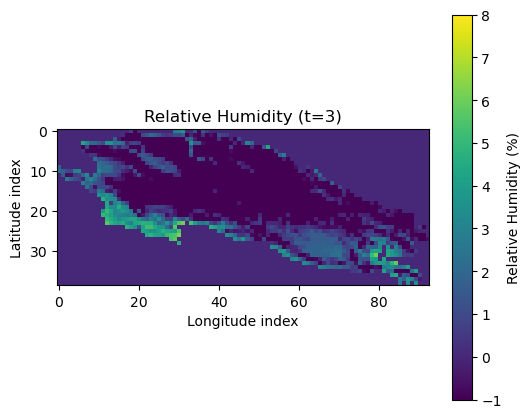

In [48]:

import matplotlib.pyplot as plt

t = 3 # time index

RH = np.load("../data_input/permafrost_yearly/1979/temperature/1.84.npy")
print(RH.shape)

plt.figure(figsize=(6, 5))
plt.imshow(
    RH[:, :, t],
    cmap="viridis",
    vmin=-1,
    vmax=8,
)
plt.colorbar(label="Relative Humidity (%)")
plt.title(f"Relative Humidity (t={t})")
plt.xlabel("Longitude index")
plt.ylabel("Latitude index")
plt.show()



In [29]:
import os
import numpy as np
import pandas as pd

data_root = '/Volumes/thesisDrive/Permafrost Data TP/daily/Permafrost data/Daily'

# === Config ===
years = range(1979, 2019)   # change as needed

# === Output folder ===
output_folder = "../data_input/permafrost_yearly"
os.makedirs(output_folder, exist_ok=True)

# === Loop through each year ===
for year in years:
    print(f"\nProcessing year {year}...")

    year_folder = os.path.join(output_folder, str(year))
    os.makedirs(year_folder, exist_ok=True)

    # Determine number of days
    ntime = 366 if pd.Timestamp(year=year, month=12, day=31).is_leap_year else 365

    # Initialize 3D ET array
    yearly_et = np.zeros((nrow, ncol, ntime), dtype=np.float32)

    # === Loop over grid points ===
    for idx, row in pts.iterrows():

        lat, lon = row["Latitude"], row["Longitude"]
        r, c = int(row["row"]), int(row["col"])

        folder_name = f"{lon}_{lat}"
        file_path = os.path.join(data_root, folder_name, "water.txt")

        if not os.path.exists(file_path):
            print(f"Missing file: {file_path}")
            continue

        # ---------------------------------------------------------
        # AUTO-DETECT HEADER LINE (find line starting with "DAY")
        # ---------------------------------------------------------
        try:
            with open(file_path, "r") as f:
                lines = f.readlines()

            header_line_index = None
            for i, line in enumerate(lines):
                if line.strip().startswith("DAY"):
                    header_line_index = i
                    break

            if header_line_index is None:
                print(f"Header not found in {file_path}")
                continue

            # Read file using detected header row
            df = pd.read_csv(
                file_path,
                sep=r"\s+",
                skiprows=header_line_index,
                engine="python"
            )

        except Exception as e:
            print(f"Error reading {file_path}: {e}")
            continue

        # ---------------------------------------------------------
        # CLEAN COLUMNS
        # ---------------------------------------------------------
        df.columns = df.columns.str.strip()

        if "YR" not in df.columns or "ET" not in df.columns:
            print(f"'YR' or 'ET' column missing in {file_path}")
            print("Detected columns:", df.columns.tolist())
            continue

        # Force numeric types
        df["YR"] = pd.to_numeric(df["YR"], errors="coerce")
        df["ET"] = pd.to_numeric(df["ET"], errors="coerce")

        # ---------------------------------------------------------
        # FILTER YEAR
        # ---------------------------------------------------------
        df_year = df[df["YR"] == year].reset_index(drop=True)

        if df_year.empty:
            continue

        # ---------------------------------------------------------
        # FILL DAILY ARRAY
        # ---------------------------------------------------------
        ndays_available = min(len(df_year), ntime)
        yearly_et[r, c, :ndays_available] = df_year["ET"].values[:ndays_available]


    # -------------------------------------------------------------
    # SAVE OUTPUT
    # -------------------------------------------------------------
    npy_path = os.path.join(year_folder, "ET.npy")
    np.save(npy_path, yearly_et)

    print(f"Saved: {npy_path}")

print("\nAll years processed!")



Processing year 1979...
Saved: ../data_input/permafrost_yearly/1979/ET.npy

Processing year 1980...
Saved: ../data_input/permafrost_yearly/1980/ET.npy

Processing year 1981...
Saved: ../data_input/permafrost_yearly/1981/ET.npy

Processing year 1982...
Saved: ../data_input/permafrost_yearly/1982/ET.npy

Processing year 1983...
Saved: ../data_input/permafrost_yearly/1983/ET.npy

Processing year 1984...
Saved: ../data_input/permafrost_yearly/1984/ET.npy

Processing year 1985...
Saved: ../data_input/permafrost_yearly/1985/ET.npy

Processing year 1986...
Saved: ../data_input/permafrost_yearly/1986/ET.npy

Processing year 1987...
Saved: ../data_input/permafrost_yearly/1987/ET.npy

Processing year 1988...
Saved: ../data_input/permafrost_yearly/1988/ET.npy

Processing year 1989...
Saved: ../data_input/permafrost_yearly/1989/ET.npy

Processing year 1990...
Saved: ../data_input/permafrost_yearly/1990/ET.npy

Processing year 1991...
Saved: ../data_input/permafrost_yearly/1991/ET.npy

Processing 

In [34]:
"""
Compute Active Layer Thickness (ALT) and Available Soil Moisture (ASM)
from soil temperature and soil moisture profiles.

For each year (1979-2018):
    1. Loads daily soil temperature arrays for each depth node and computes
       the active layer bottom depth — the deepest CONTIGUOUSLY thawed layer
       from the surface downward.
    2. Loads daily liquid soil moisture arrays for each depth node and
       sums moisture over all layers within the active layer to produce
       total available soil moisture (mm) for each grid cell and day.

Active layer definition:
    Contiguous thawed zone from the surface downward. If a frozen node is
    encountered, the active layer stops at the bottom of the previous thawed
    node — even if deeper nodes are also thawed.

The surface node (centered at 0.00m, zero thickness) is excluded from
both temperature and soil moisture calculations.

Since ALT is always snapped to a layer bottom depth, no layer can be
partially within the active layer — a layer is either fully included or
fully excluded.

Inputs:
    Temperature  : <BASE_DIR>/<year>/temperature/<depth>.npy
    Soil moisture: <SM_DIR>/<year>/soil moisture/<depth>.npy
    Each file shape: (rows, cols, 365)
    Units: temperature in °C, soil moisture in m³/m³ (volumetric liquid)

Outputs:
    active_layer_<year>.npy       : Active layer bottom depth (m), shape (rows, cols, 365)
    avail_soil_moisture_<year>.npy: Total liquid soil moisture in active layer (mm),
                                    shape (rows, cols, 365)
"""

import numpy as np
import os

# -----------------------------------------------------------------------
# Configuration
# -----------------------------------------------------------------------

# Base directory for temperature data
BASE_DIR = '../data_input/permafrost_yearly'

# Base directory for soil moisture data
SM_DIR = '../data_input/permafrost_yearly'

# Output directory
OUT_DIR = '../data_input/permafrost_yearly'
os.makedirs(OUT_DIR, exist_ok=True)

# Years to process
YEARS = range(1979, 2019)

# Depth nodes — surface node (0.00m) excluded
CENTER_DEPTHS = [0.02, 0.07, 0.13, 0.23, 0.39, 0.66, 1.11, 1.84, 2.75]

# Bottom depth (m) of each layer — ALT is always one of these values
BOTTOM_DEPTHS = [0.04, 0.10, 0.16, 0.30, 0.48, 0.84, 1.36, 2.32, 3.18]

# Thickness (m) of each layer — used to convert m³/m³ to mm
# Top of layer 0 is 0.00m; top of each subsequent layer = bottom of previous
THICKNESSES = [0.04, 0.06, 0.06, 0.14, 0.18, 0.36, 0.52, 0.96, 0.86]

# Temperature threshold for thaw
THAW_THRESHOLD = 0.0

# -----------------------------------------------------------------------
# Main processing loop
# -----------------------------------------------------------------------

bottom_depths_arr = np.array(BOTTOM_DEPTHS)  # (n_depths,)
thicknesses_arr   = np.array(THICKNESSES)    # (n_depths,)

for year in YEARS:
    print(f'Processing year {year}...')

    # -------------------------------------------------------------------
    # Load temperature and soil moisture stacks
    # Shape: (n_depths, rows, cols, 365)
    # -------------------------------------------------------------------
    temp_stack = []
    sm_stack   = []

    for depth in CENTER_DEPTHS:
        depth_str = f'{depth:.2f}'

        t_path = os.path.join(BASE_DIR, str(year), 'temperature',   f'{depth_str}.npy')
        s_path = os.path.join(SM_DIR,   str(year), 'soil moisture',  f'{depth_str}.npy')

        temp_stack.append(np.load(t_path))
        sm_stack.append(np.load(s_path))

    temp_stack = np.array(temp_stack)  # (n_depths, rows, cols, 365)
    sm_stack   = np.array(sm_stack)    # (n_depths, rows, cols, 365)

    n_depths, rows, cols, days = temp_stack.shape

    # -------------------------------------------------------------------
    # Step 1: Compute active layer bottom depth (ALT)
    # -------------------------------------------------------------------
    thawed       = temp_stack > THAW_THRESHOLD          # (n_depths, rows, cols, 365)
    alt          = np.zeros((rows, cols, days), dtype=np.float32)
    still_thawed = np.ones( (rows, cols, days), dtype=bool)

    for d_idx in range(n_depths):

        contiguous = thawed[d_idx] & still_thawed

        # Assign this layer's bottom depth where contiguously thawed
        alt = np.where(contiguous, bottom_depths_arr[d_idx], alt)

        # Block columns that hit a frozen node
        still_thawed = still_thawed & thawed[d_idx]

        if not still_thawed.any():
            break

    # -------------------------------------------------------------------
    # Step 2: Compute total available soil moisture (ASM) in mm
    # -------------------------------------------------------------------
    # Since ALT is always a layer bottom depth, each layer is either:
    #   - Fully included  : layer bottom depth <= ALT
    #   - Fully excluded  : layer bottom depth >  ALT
    # No partial layers exist.
    #
    # ASM (mm) = sum over included layers of: sm (m³/m³) × thickness (m) × 1000

    asm = np.zeros((rows, cols, days), dtype=np.float32)

    for d_idx in range(n_depths):

        # Layer is included wherever its bottom depth <= ALT
        included = (alt >= bottom_depths_arr[d_idx])  # (rows, cols, 365) boolean

        # Add this layer's contribution: volumetric moisture × thickness × 1000 → mm
        asm += np.where(included, sm_stack[d_idx] * thicknesses_arr[d_idx] * 1000.0, 0.0)

    # -------------------------------------------------------------------
    # Step 3: Save outputs
    # -------------------------------------------------------------------
    alt_path = os.path.join(OUT_DIR, str(year),f'active_layer_depth.npy')
    asm_path = os.path.join(OUT_DIR, str(year), f'avail_soil_moisture.npy')

    np.save(alt_path, alt)
    np.save(asm_path, asm)

    print(f'  ALT saved : {alt_path}  shape={alt.shape}')
    print(f'  ASM saved : {asm_path}  shape={asm.shape}')

print('Done.')

Processing year 1979...
  ALT saved : ../data_input/permafrost_yearly/1979/active_layer_depth.npy  shape=(39, 93, 365)
  ASM saved : ../data_input/permafrost_yearly/1979/avail_soil_moisture.npy  shape=(39, 93, 365)
Processing year 1980...
  ALT saved : ../data_input/permafrost_yearly/1980/active_layer_depth.npy  shape=(39, 93, 366)
  ASM saved : ../data_input/permafrost_yearly/1980/avail_soil_moisture.npy  shape=(39, 93, 366)
Processing year 1981...
  ALT saved : ../data_input/permafrost_yearly/1981/active_layer_depth.npy  shape=(39, 93, 365)
  ASM saved : ../data_input/permafrost_yearly/1981/avail_soil_moisture.npy  shape=(39, 93, 365)
Processing year 1982...
  ALT saved : ../data_input/permafrost_yearly/1982/active_layer_depth.npy  shape=(39, 93, 365)
  ASM saved : ../data_input/permafrost_yearly/1982/avail_soil_moisture.npy  shape=(39, 93, 365)
Processing year 1983...
  ALT saved : ../data_input/permafrost_yearly/1983/active_layer_depth.npy  shape=(39, 93, 365)
  ASM saved : ../data

(39, 93, 365)


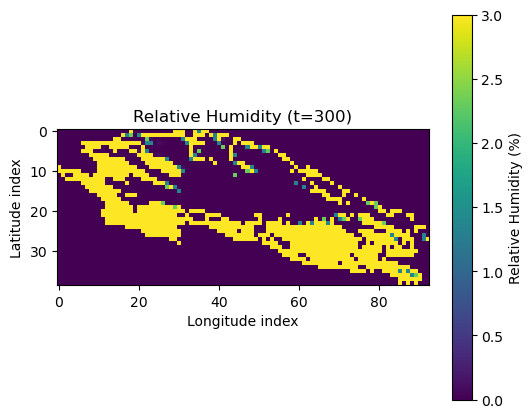

In [39]:

import matplotlib.pyplot as plt

t = 300 # time index

RH = np.load("../data_input/permafrost_yearly/2018/active_layer_depth.npy")
print(RH.shape)

plt.figure(figsize=(6, 5))
plt.imshow(
    RH[:, :, t],
    cmap="viridis",
    vmin=0,
    vmax=3,
)
plt.colorbar(label="Relative Humidity (%)")
plt.title(f"Relative Humidity (t={t})")
plt.xlabel("Longitude index")
plt.ylabel("Latitude index")
plt.show()

